In [381]:
import warnings; warnings.simplefilter('ignore')

In [2]:
import json, pymongo, pandas, scipy
import numpy as np

In [3]:
% pylab inline

Populating the interactive namespace from numpy and matplotlib


In [9]:
def connect_to_database(): 
    # load credentials to access the database, connect, identify collection
    data = json.load(open('../experiment/.credentials/auth.json'))
    mongo_tunnel = 'mongodb://' + data['user'] + ':' + data['password'] + '@127.0.0.1'
    connection = pymongo.MongoClient(mongo_tunnel)
    data_base = connection['sleep_affect_memory']
    collection = data_base['replication']
    return collection

In [10]:
def identify_workers(collection):
    
    # the second is my worker id
    exclude = ['NONE', 'A33F2FVAMGJDGG']
    all_workers = [i for i in collection.distinct('worker_id') if i not in exclude]
    complete = [] 
    # extract workers who've completed entire experiment -- not returned HIT early
    for i_worker in all_workers: 
        tmp_data = collection.find({'worker_id':i_worker})
        if 'worker_feedback' in tmp_data[tmp_data.count()-1]['trial_data']: 
            complete.append(i_worker)
    
    return complete

In [11]:
def extract_data(w_ids): 
    
    # columns to exclude 
    ignore = ['trial_index', 
              'time_elapsed', 
              'stimulus', 
              'correct_response', 
              'internal_node_id', 
              'trial_type']
    
    subject_trial_data = pandas.DataFrame()
    
    # iterate over workers 
    for i_worker in w_ids: 
        
        # extract worker's data from mongo database
        i_data = collection.find({'worker_id':i_worker})

        for one_trial in i_data: 
            
            # extract all data we want 
            if 'worker_feedback' not in one_trial['trial_data'].keys(): 
                q = {i:one_trial['trial_data'][i] for i in list(one_trial['trial_data'].keys()) if i not in ignore}
                q['subject'] = one_trial['worker_id']
                subject_trial_data = subject_trial_data.append(q, ignore_index=True)
    
    # convert to absolute value of distance
    subject_trial_data.distance = np.abs(subject_trial_data.distance)
    
    return subject_trial_data

In [12]:
collection = connect_to_database()
worker_ids = identify_workers(collection)
trial_data = extract_data(worker_ids)

In [13]:
generalization_data = trial_data[trial_data.stage=='generalization']
generalization_data = generalization_data[generalization_data.valence!='control']

In [14]:
response_mapping = {80:'positive',81:'negative',32:'neutral'}
generalization_data['response'] = [response_mapping[i] for i in generalization_data.key_press.values]
generalization_data['distance'] = abs(generalization_data['distance'])

In [15]:
main_question_conditions = (generalization_data.valence != 'control')
valence_by_distance = generalization_data[main_question_conditions][['response', 'distance', 'valence']]

In [16]:
valence_by_distance[0:10]

,response,distance,valence
33,positive,5.0,positive
34,positive,5.0,positive
35,positive,20.0,positive
36,positive,0.0,negative
37,neutral,20.0,negative
38,negative,5.0,negative
39,positive,20.0,positive
42,neutral,100.0,positive
43,negative,100.0,negative
44,positive,0.0,positive


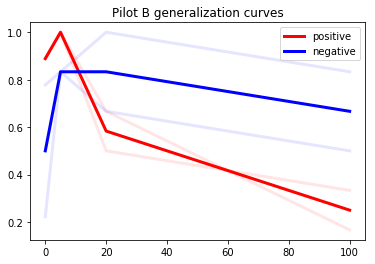

In [404]:
colores = {'positive':'red', 'negative':'blue'}

distances = np.sort(generalization_data.distance.unique())
all_things = {'positive':[], 'negative':[]}

for i_subject in generalization_data.subject.unique(): 
    
    for i_valence in ['positive', 'negative']: 
        
        things = [] 
        
        for i_distance in distances: 
        
            gen = generalization_data[generalization_data.subject==i_subject]
            conditions = (gen.valence==i_valence)*(gen.distance==i_distance)
            things.append(mean(gen.response[conditions] == gen.valence[conditions]))
        
        all_things[i_valence].append(things)
        plot(distances, things, color=colores[i_valence], alpha=.1, linewidth=3)

plot(distances, np.mean(all_things['positive'],0), color='red', linewidth=3, label='positive')
plot(distances, np.mean(all_things['negative'],0), color='blue', linewidth=3, label='negative')
title('Pilot B generalization curves')
legend() ; 

In [362]:
def get_pilot_subject(name_of_iteration): 

    # extract worker's data from mongo database
    i_data = collection.find({'iteration_name':name_of_iteration})

    ignore = ['trial_index', 
              'time_elapsed', 
              'stimulus', 
              'correct_response', 
              'internal_node_id', 
              'trial_type']

    person_data = pandas.DataFrame()

    for one_trial in i_data: 

        # extract all data we want 
        if 'worker_feedback' not in one_trial['trial_data'].keys(): 
            
            q = {i:one_trial['trial_data'][i] for i in list(one_trial['trial_data'].keys()) if i not in ignore}
            q['subject'] = one_trial['worker_id']
            person_data = person_data.append(q, ignore_index=True)
    
    return person_data

In [363]:
def generalization_curves(gen_data, data_type, name): 

    gen_curves = {}
    distances = np.sort(gen_data['distance'].unique())
    colores = {'positive':'red', 'negative':'blue'}

    for i_valence in ['positive', 'negative']: 

        gen_rates = [] 
        gen_sems = []
        
        for i_distance in distances: 

            conditions = (gen_data.valence==i_valence) * (gen_data.distance==i_distance)
            
            if data_type == 'valence': 
                choices = gen_data.response[conditions] == gen_data.valence[conditions]
            elif data_type == 'rt': 
                choices = gen_data.rt[conditions]
                choices = [i for i in choices if i != None]
            
            gen_rates.append(mean(choices))
            gen_sems.append(scipy.stats.sem(choices))
            
        gen_rates = np.array(gen_rates)
        gen_sems = np.array(gen_sems)
        gen_curves[i_valence] = gen_rates
        plot(distances, gen_rates, linewidth=3, label=i_valence, color=colores[i_valence], alpha=.5)
        fill_between(distances, gen_rates+gen_sems, gen_rates-gen_sems, alpha=.2, color=colores[i_valence])
    
    title("%s's pilot data!"%name)
    
    if data_type == 'valence': ylabel('p( association_valence | tone )')
    elif data_type == 'rt': 
        ylabel('Reaction time')
        ylim([0,2000])
    xlabel('Distance from original tone')
    legend()


In [364]:
def preprocess_subject(subject_data, key_map): 
    
    subject_gen = subject_data[subject_data.stage=='generalization']
    subject_gen = subject_gen[subject_gen.valence!='control']
    subject_gen['distance'] = np.abs(subject_gen['distance'])
    
    if key_map=='first': 
        responses = {81:'negative',80:'positive',32:'neutral',None:None}
    else: 
        responses = {80:'negative',81:'positive',32:'neutral',None:None}
        
    subject_gen['response'] = [responses[i] for i in subject_gen.key_press.values]
    
    return subject_gen

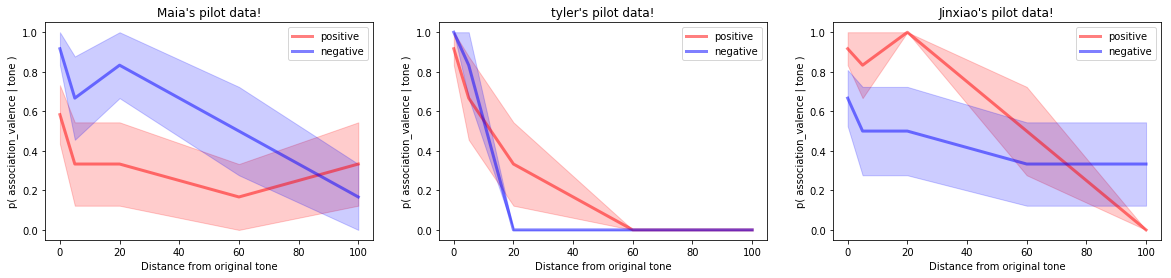

In [379]:

# load Maia's data
maia_data = get_pilot_subject('maia_test')
# preprocess
maia_g_data = preprocess_subject(maia_data, 'first')
# plot generaliation curves
figure(figsize=[20,4])
subplot(131) ; generalization_curves(maia_g_data, 'valence',  "Maia")

# extract tyler's data
tyler_data = get_pilot_subject('tyler_final_pilot')
# preprocess
tyler_g_data = preprocess_subject(tyler_data, 'first') 
# plot generalization curve
subplot(132); generalization_curves(tyler_g_data, 'valence', "tyler")

# extract tyler's data
jinxiao_data = get_pilot_subject('jinxiao_test')
# preprocess
jinxiao_g_data = preprocess_subject(jinxiao_data, 'second ') 
# plot generalization curve
subplot(133); generalization_curves(jinxiao_g_data, 'valence', "Jinxiao")


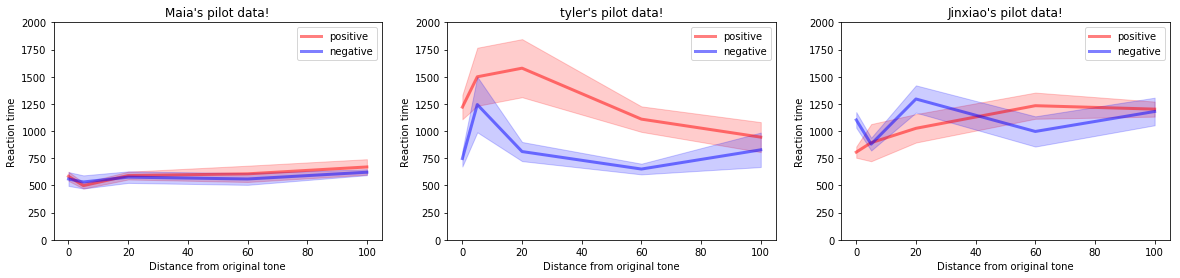

In [378]:
figure(figsize=[20,4])
subplot(131)
generalization_curves(maia_g_data, 'rt', 'Maia')
subplot(132)
generalization_curves(tyler_g_data, 'rt', 'tyler')
subplot(133)
generalization_curves(jinxiao_g_data, 'rt', 'Jinxiao')

In [402]:
collection.find({'iteration_name':'pilot_3'})[450]

{'_id': ObjectId('5c05c46a07aab50b0dfac6a8'),
 'trial_data': {'rt': 602,
  'stimulus': 'sound/705',
  'key_press': 32,
  'stage': 'generalization',
  'correct_response': 'space',
  'tone': 705,
  'valence': 'negative',
  'distance': 5,
  'trial_type': 'audio-keyboard-response',
  'trial_index': 362,
  'time_elapsed': 446767,
  'internal_node_id': '0.0-10.0-1.22',
  'correct': True,
  'i_generalization_trial': 52,
  'i_block': 1},
 'data_type': 'single_trial',
 'iteration_name': 'pilot_3',
 'context': 'acquisition',
 'worker_id': 'A1WY3YGT618GC0',
 'assignment_id': '3L0KT67Y8EG7P8F80XE8JJ6J4BPYSW',
 'hit_id': '356TQKY9XFX34K659ND20VQTAL6784',
 'browser': 'Chrome'}

In [390]:
import json, pymongo, pandas
import numpy as np
import matplotlib.pyplot as plt 
import warnings; warnings.simplefilter('ignore')
  
auth_path = "/Users/biota/memory/sleep_affect_memory/experiment/.credentials/auth.json"
  
def connect_to_database(): 

    # load credentials to access the database, connect, identify collection
    data = json.load(open(auth_path))
    mongo_tunnel = 'mongodb://' + data['user'] + ':' + data['password'] + '@127.0.0.1'
    connection = pymongo.MongoClient(mongo_tunnel)
    data_base = connection['sleep_affect_memory']
    collection = data_base['replication']
    
    return collection
    
def identify_workers(collection):

    # the second is my worker id
    exclude = ['NONE', 'A33F2FVAMGJDGG']
    all_workers = [i for i in collection.find({'iteration_name':'pilot_3'}).distinct('worker_id') if i not in exclude]
    # extract workers who've completed entire experiment -- not returned HIT early
    
    
    complete = [] 
    for i_worker in all_workers: 
        tmp_data = collection.find({'worker_id':i_worker})
        if 'worker_feedback' in tmp_data[tmp_data.count()-1]['trial_data']: 
            complete.append(i_worker)
            
    return complete
    
def extract_data(): 

    # connect with mongo
    collection = connect_to_database() 
    # identify workers who completed experiment
    worker_ids = identify_workers(collection)
    # pret to remove worker identifiers 
    subject_ids = {worker_ids[i]:i for i in range(len(worker_ids))}
    # initialize data frame
    subject_trial_data = pandas.DataFrame()
    # iterate over workers 
    for i_worker in worker_ids: 
        # extract worker's data from mongo database
        i_data = collection.find({'worker_id':i_worker})
        # extract trial data
        for one_trial in i_data: 
            # only extract data we want 
            if 'worker_feedback' not in one_trial['trial_data'].keys(): 
                q = {i:one_trial['trial_data'][i] for i in list(one_trial['trial_data'].keys())}
                # use anonymized worker identifier
                q['subject'] = subject_ids[i_worker]
                subject_trial_data = subject_trial_data.append(q, ignore_index=True)
                
    return subject_trial_data
  
# extract and format data from database
data = extract_data()

# NEXT TIME SAVE THE VALENCE OF EACH KEY PRESS TYLER! 
data['positive_key'] = nan
data['negative_key'] = nan
data['association'] = nan

mapping = {'p':80, 'q':81, 'space':32}

for i_subject in data.subject.unique(): 
    
    for i_valence in ['positive', 'negative']: 
        
        conditions = (data.subject==i_subject) * (data.valence==i_valence) * (data.condition=='instrumental')
        # get the key valeu and map it to the numerical value
        i_key = mapping[np.unique(data[conditions]['correct_response'])[0]]
        
        # update subject valence-key mapping 
        data['%s_key'%i_valence][data.subject==i_subject] = int(i_key)
        
# save for later analysis
data.to_csv('subject_data.csv')

In [393]:
for i in collection.find({'iteration_name':'pilot_3'}): 
    if 'worker_feedback' in i['trial_data']: 
        print(i['trial_data']['worker_feedback'], end='\n\n')

{"Q0":"great job tyler! :D "}

{"Q0":"Experiment was a little interesting. It was also pretty boring but I'm not sure it's possible to avoid that. The bonus amount for time spent is alright, not bad but not overly generous either."}

{"Q0":"I thought it was interesting and challenging. I think the bonus was fair but that's mostly because I did pretty well. It took me 11 minutes to complete, so someone earning say a $0.50 cent bonus might have an issue with the base pay. My bonus plus the base pay is fair compensation. "}

{"Q0":"This was very difficult but enjoyable. I found that I had a hard time distinguishing between the neutral and positive sounds with the time constraint. I would realize after I pressed the positive key that I had actually heard the neutral sound, but had reacted quickly on instinct. Also, part two was incredibly challenging. I could tell that there were different tones but due to the quick reaction time, I knew I was making a lot of mistakes. I just tried to be a